In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense,Conv1D, MaxPooling1D, LSTM, Bidirectional,Dropout
from keras.utils.np_utils import to_categorical
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
dataset = pd.read_csv('./data1.csv')
X = dataset.iloc[:, -500:]
y = dataset.iloc[:, 0].values

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)

In [5]:
XTrain, XValTest, yTrain, yValTest = train_test_split(scaled, y, test_size=0.4)
XVal, XTest, yVal, yTest = train_test_split(XValTest, yValTest, test_size=0.5)

In [6]:
yTrain_one_hot = to_categorical(yTrain, 2)
yVal_one_hot = to_categorical(yVal, 2)

In [7]:
XTrain = np.array(XTrain)
XVal = np.array(XVal)

In [8]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XVal = XVal.reshape((XVal.shape[0], 1, XVal.shape[1]))

In [9]:
model = keras.Sequential()
model.add(LSTM(20, activation="relu", return_sequences=True)) #输出维度是20
model.add(LSTM(50, activation="relu", return_sequences=False))
model.add(Dense(10, activation="relu", kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.build(input_shape=(3600,1,500))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (3600, 1, 20)             41680     
                                                                 
 lstm_1 (LSTM)               (3600, 50)                14200     
                                                                 
 dense (Dense)               (3600, 10)                510       
                                                                 
 dropout (Dropout)           (3600, 10)                0         
                                                                 
 dense_1 (Dense)             (3600, 2)                 22        
                                                                 
Total params: 56,412
Trainable params: 56,412
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
history = model.fit(XTrain, yTrain_one_hot, epochs=60, batch_size=1024, verbose=1,
                    validation_data=(XVal, yVal_one_hot))

Epoch 1/60
4/4 [==============================] - 2s 84ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 2/60
4/4 [==============================] - 0s 18ms/step - loss: 0.6930 - accuracy: 0.5064 - val_loss: 0.6928 - val_accuracy: 0.5208
Epoch 3/60
4/4 [==============================] - 0s 31ms/step - loss: 0.6928 - accuracy: 0.5064 - val_loss: 0.6926 - val_accuracy: 0.5208
Epoch 4/60
4/4 [==============================] - 0s 27ms/step - loss: 0.6925 - accuracy: 0.5064 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 5/60
4/4 [==============================] - 0s 26ms/step - loss: 0.6920 - accuracy: 0.5106 - val_loss: 0.6916 - val_accuracy: 0.5317
Epoch 6/60
4/4 [==============================] - 0s 26ms/step - loss: 0.6912 - accuracy: 0.5242 - val_loss: 0.6906 - val_accuracy: 0.5433
Epoch 7/60
4/4 [==============================] - 0s 30ms/step - loss: 0.6902 - accuracy: 0.6022 - val_loss: 0.6893 - val_accuracy: 0.6425
Epoch 8/60
4/4 [===========

In [12]:
model.save('LSTM_model.h5')

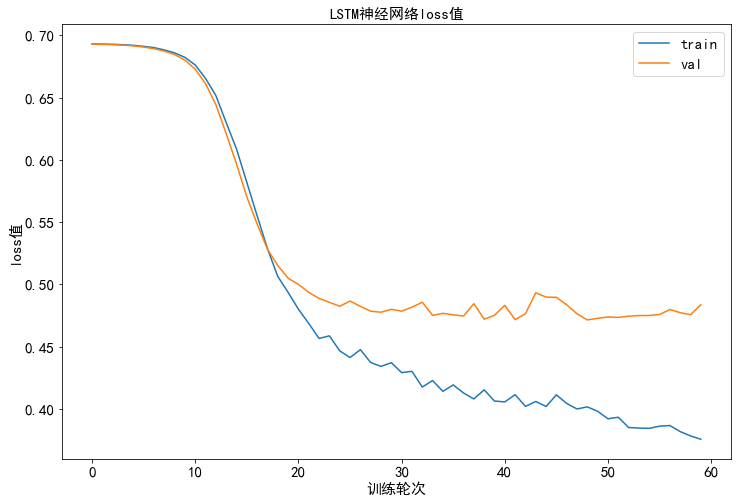

38/38 [==============================] - 0s 3ms/step - loss: 0.4837 - accuracy: 0.7825
预测准确率: 0.7825000286102295
              precision    recall  f1-score   support

        NLOS       0.75      0.88      0.81       625
         LOS       0.84      0.68      0.75       575

    accuracy                           0.78      1200
   macro avg       0.79      0.78      0.78      1200
weighted avg       0.79      0.78      0.78      1200



In [13]:
# 绘制训练集和测试集的loss值对比图
# 创建一个大小为（12，8）的画布
plt.figure(figsize=(12, 8))

# 传入训练集的loss和验证集的loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')

# 设置图的参数，设置图的名字
plt.title("LSTM神经网络loss值", fontsize=15)

# 设置xy轴的刻度值大小
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 设置xy轴的标签
plt.ylabel('loss值', fontsize=15)
plt.xlabel('训练轮次', fontsize=15)

# 设置图例文字大小
plt.legend(fontsize=15)
plt.show()

y_predetion = np.argmax(model.predict(XVal), axis=-1)
y_pred = []
for i in range(len(y_predetion)):
    y_pred.append(y_predetion[i])

y_Val = []
for i in range(len(yVal)):
    y_Val.append(yVal[i])
scores = model.evaluate(XVal, yVal_one_hot)
print("预测准确率:", scores[1])


report = classification_report(y_Val, y_pred, labels=[0, 1],
                               target_names=['NLOS', 'LOS'])
print(report)

In [14]:
from keras.models import load_model

In [15]:
yTest_one_hot = to_categorical(yTest, 2)
XTest = np.array(XTest)
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
model = load_model("LSTM_model.h5")

y_predetion = np.argmax(model.predict(XTest), axis=-1) #取这一行中最大值的下标
y_pred = []
for i in range(len(y_predetion)):
    y_pred.append(y_predetion[i])

y_Test = []
for i in range(len(yTest)):
    y_Test.append(yTest[i])
scores = model.evaluate(XTest, yTest_one_hot)
print("预测准确率:", scores[1])

report = classification_report(y_Test, y_pred, labels=[0, 1],
                               target_names=['NLOS', 'LOS'])
print(report)


38/38 [==============================] - 1s 4ms/step - loss: 0.4425 - accuracy: 0.8192
预测准确率: 0.8191666603088379
              precision    recall  f1-score   support

        NLOS       0.76      0.91      0.83       584
         LOS       0.90      0.73      0.81       616

    accuracy                           0.82      1200
   macro avg       0.83      0.82      0.82      1200
weighted avg       0.83      0.82      0.82      1200

